# Import Libraries and Data

In [1]:
import ibis
import pandas as pd
import os

In [2]:
import getpass 
  
try: 
    
    p = getpass.getpass() 
except Exception as error: 
    print('ERROR', error) 
else: 
    print('Password entered:') 

········
Password entered:


### Import Data from Impala

In [3]:
hdfs = ibis.hdfs_connect(host=os.environ['HDFS_HOST'], port=50070)

In [4]:
client_impala = ibis.impala.connect(host=os.environ['IP_IMPALA'], port=21050, \
  hdfs_client=hdfs, user=os.environ['CHANDIMA_LOGIN'], password=getpass.getpass(), \
  auth_mechanism='PLAIN')


········


In [5]:
%%time
requete =client_impala.sql('SELECT * FROM open_data.clean_bank')
df = requete.execute()

CPU times: user 196 ms, sys: 4 ms, total: 200 ms
Wall time: 382 ms


In [6]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000000,1,1,1,101348.882812,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.859375,1,0,1,112542.578125,0
2,3,15619304,Onio,502,France,Female,42,8,159660.796875,3,1,0,113931.570312,1
3,4,15701354,Boni,699,France,Female,39,1,0.000000,2,0,0,93826.632812,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820312,1,1,1,79084.101562,0


In [7]:
df.dtypes

rownumber            int32
customerid           int32
surname             object
creditscore          int32
geography           object
gender              object
age                  int32
tenure               int32
balance            float32
numofproducts        int32
hascrcard            int32
isactivemember       int32
estimatedsalary    float32
exited               int32
dtype: object

### Check co-relation between the features

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

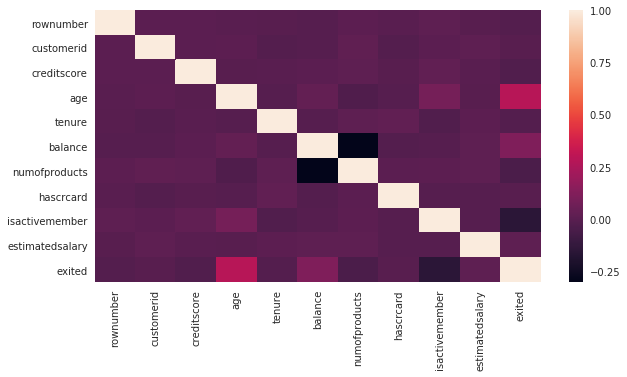

In [48]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr())

# Identify the Distribution of Data

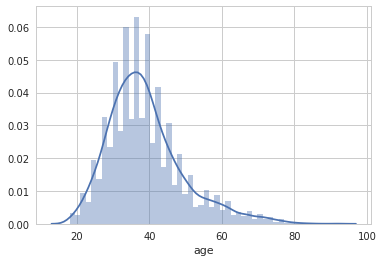

In [10]:
copy = df.copy()
copy.dropna(inplace = True)
sns.distplot(copy["age"])

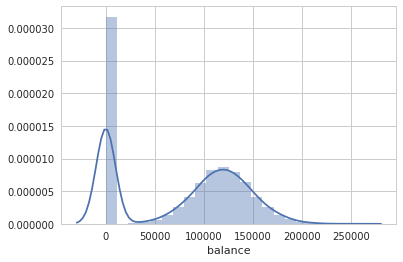

In [11]:
copy = df.copy()
copy.dropna(inplace = True)
sns.distplot(copy["balance"])

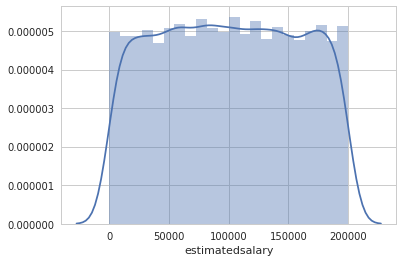

In [12]:
copy = df.copy()
copy.dropna(inplace = True)
sns.distplot(copy["estimatedsalary"])

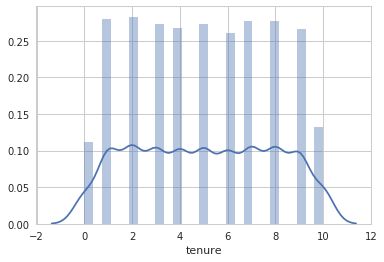

In [13]:
copy = df.copy()
copy.dropna(inplace = True)
sns.distplot(copy["tenure"])

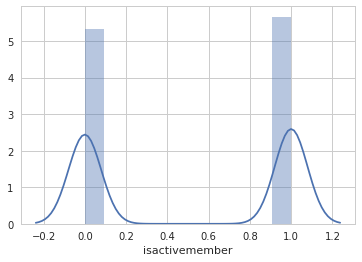

In [14]:
copy = df.copy()
copy.dropna(inplace = True)
sns.distplot(copy["isactivemember"])

Age and Balance are normaly distributed. Tenure and isactivemember are uniformly disributed. These distibutions are useful when to replace null values. Either by mean or median.

# Plots and Visualization

### Customer Exited vs Not Exited

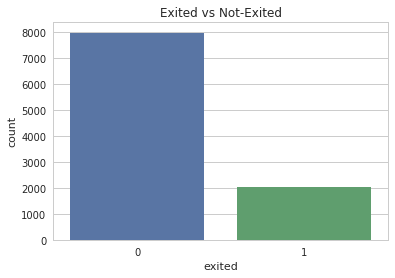

In [59]:
sns.countplot(x="exited", data=df)
plt.title("Exited vs Not-Exited")
plt.show()

### Churn according to Gender

Text(0.5,1,'Churn with Gender')

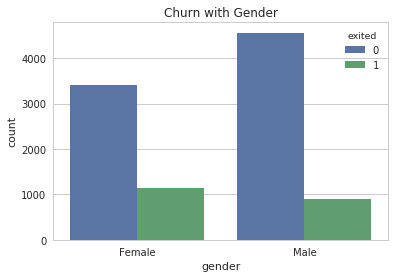

In [58]:
sns.countplot('gender',data=df,hue='exited').set_title('Churn with Gender')

### Churn according to Geography

Text(0.5,1,'Churn According to Geography')

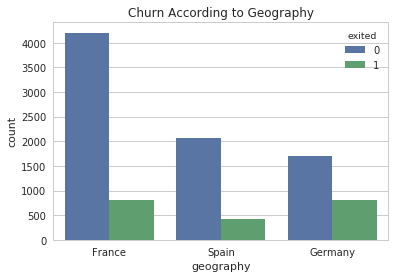

In [17]:
sns.countplot('geography',data=df,hue='exited').set_title('Churn According to Geography')

### Churn acording to Age Group

In [18]:
age_cat = df[['age','exited']]

In [19]:
age_cat.head()

,age,exited
0,42,1
1,41,0
2,42,1
3,39,0
4,43,0


In [20]:
r = [0, 15, 25, 35, 45, 55,120]
g = ['Children 0 - 15','Teenagers 16-25','Youth 26-35','Adult 36- 45','Mature 46- 55','Old 56+']
age_cat['Age_Category'] = pd.cut(age_cat['age'], bins=r, labels=g)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


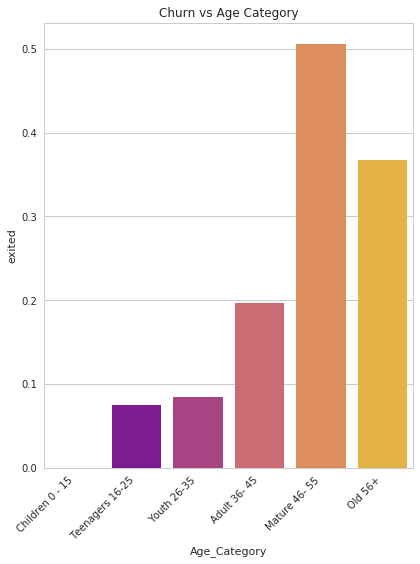

In [21]:
df_3 = age_cat.groupby('Age_Category').mean()
df_3.reset_index(inplace=True)
plt.figure(figsize=(6,8))
sns.barplot(x='Age_Category', y='exited', data=df_3,palette='plasma').set_title('Churn vs Age Category')
plt.xticks(plt.xticks()[0],g , rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Feature Engineering

### One-Hot encoding our categorical attributes

In [22]:
list_cat = ['geography', 'gender']
training_data = pd.get_dummies(df, columns = list_cat, prefix = list_cat)

In [23]:
training_data.head()

,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,1,15634602,Hargrave,619,42,2,0.000000,1,1,1,101348.882812,1,1,0,0,1,0
1,2,15647311,Hill,608,41,1,83807.859375,1,0,1,112542.578125,0,0,0,1,1,0
2,3,15619304,Onio,502,42,8,159660.796875,3,1,0,113931.570312,1,1,0,0,1,0
3,4,15701354,Boni,699,39,1,0.000000,2,0,0,93826.632812,0,1,0,0,1,0
4,5,15737888,Mitchell,850,43,2,125510.820312,1,1,1,79084.101562,0,0,0,1,1,0


### Feature Rescaling

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

In [25]:
#We need to reshape our data since the Scaler takes in arrays
creditscore_train = np.array(training_data["creditscore"]).reshape(-1, 1)
age_train = np.array(training_data["age"]).reshape(-1, 1)
balance_train = np.array(training_data["balance"]).reshape(-1, 1)
estimatedsalary_train = np.array(training_data["estimatedsalary"]).reshape(-1, 1)

training_data["creditscore"] = scaler.fit_transform(creditscore_train)
training_data["age"] = scaler.fit_transform(age_train)
training_data["balance"] = scaler.fit_transform(balance_train)
training_data["estimatedsalary"] = scaler.fit_transform(estimatedsalary_train)

In [26]:
training_data.head()

,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,1,15634602,Hargrave,-0.326221,0.293517,2,-1.225848,1,1,1,0.021887,1,1,0,0,1,0
1,2,15647311,Hill,-0.440036,0.198164,1,0.117350,1,0,1,0.216534,0,0,0,1,1,0
2,3,15619304,Onio,-1.536794,0.293517,8,1.333053,3,1,0,0.240687,1,1,0,0,1,0
3,4,15701354,Boni,0.501521,0.007457,1,-1.225848,2,0,0,-0.108918,0,1,0,0,1,0
4,5,15737888,Mitchell,2.063884,0.388871,2,0.785728,1,1,1,-0.365276,0,0,0,1,1,0


# Split the Data Frame

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, test = train_test_split(training_data, test_size=0.2)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [30]:
X_train = train.drop(['exited','rownumber','customerid','surname'], axis=1).values
y_train = train["exited"].values
X_test = test.drop(['exited','rownumber','customerid','surname'], axis=1).values

In [31]:
X_train.shape, y_train.shape, X_test.shape

((8000, 13), (8000,), (2000, 13))

### Import XGBClassifier from xgboost 

We use only one model to prediction

In [32]:
from xgboost import XGBClassifier

Import libraries to check the accruracy of the model. 
Precision, Recall and F1 score to see how many times you predicted correctly

In [33]:
from sklearn.metrics import make_scorer, accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Find out the best hyper parameters 

In [34]:
from sklearn.model_selection import GridSearchCV

### Create validation Data Set: to avoid overfitting

In [35]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [36]:


xg_clf = XGBClassifier()

parameters_xg = {"objective" : ["reg:linear"], "n_estimators" : [5, 10, 15, 20]}

grid_xg = GridSearchCV(xg_clf, parameters_xg, scoring=make_scorer(accuracy_score))
grid_xg.fit(X_training, y_training)

xg_clf = grid_xg.best_estimator_

xg_clf.fit(X_training, y_training)
pred_xg = xg_clf.predict(X_valid)
acc_xg = accuracy_score(y_valid, pred_xg)

print("The Score for XGBoost is: " + str(acc_xg))

[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of re

In [37]:
precision_xg = precision_score(y_valid,pred_xg, average='weighted')
print("The precision of xgboost is: " + str(precision_xg))
recall_xg = recall_score(y_valid,pred_xg, average='weighted')
print("The recall of xgboost is: " + str(recall_xg))
F1_xg = recall_score(y_valid,pred_xg, average='weighted')
print("The F1 score of xgboost is: " + str(F1_xg))

The precision of xgboost is: 0.8727054858087814
The recall of xgboost is: 0.879375
The F1 score of xgboost is: 0.879375


# Model Performance Comparison

In [39]:
model_performance = pd.DataFrame({
   
    "Accuracy_Score": [acc_xg],
    "Precision": [precision_xg],
    "Recall" : [recall_xg],
    "F1 Score": [F1_xg],
     "Model": ["XGBoost"]
})


model_performance = model_performance[['Model', 'Accuracy_Score', 'Precision', 'Recall', 'F1 Score']]
model_performance

,Model,Accuracy_Score,Precision,Recall,F1 Score
0,XGBoost,0.879375,0.872705,0.879375,0.879375


Fit the model on unseen data

In [40]:
xg_clf.fit(X_train, y_train)

[09:36:18] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [41]:
result_sumbission = xg_clf.predict(X_test)

In [42]:
y_test = test["exited"].values

In [43]:
submission2 = pd.DataFrame({
        "Id": test["customerid"],
        "Customer_name":test["surname"],
        "expected_Exited": y_test,
        "predicted_Exited": result_sumbission.round()
    })

submission2 = submission2[['Id','Customer_name','expected_Exited','predicted_Exited']]

In [44]:
submission2.head()

,Id,Customer_name,expected_Exited,predicted_Exited
33,15659428,Maggard,0,0
8419,15775809,Holloway,0,0
2024,15633043,Fedorova,1,0
9940,15791972,Bergamaschi,0,0
4169,15716728,Basedow,0,0


### Check the results with confusion_matrix


In [45]:
from sklearn.metrics import confusion_matrix


In [46]:
cm = confusion_matrix(y_valid, pred_xg)
cm

array([[1256,   38],
       [ 155,  151]])

[Text(0,0.5,'1'), Text(0,1.5,'0')]

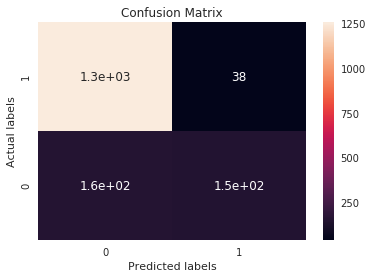

In [47]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['1', '0'])

# Save churn_bank_customers.csv file in to HDFS

In [ ]:
from hdfs import InsecureClient
client_hdfs = InsecureClient('http://192.168.56.10:50070', user=os.environ['CHANDIMA_LOGIN'])

In [ ]:
# Writing Dataframe to hdfs
with client_hdfs.write('/user/chandima.pondapelage/Bank/result_csv/churn_bank_customers.csv',encoding = 'utf-8') as writer:
    submission2.to_csv(writer)